# Problem 1 - Variational Auto-Encoder (VAE)

Variational Auto-Encoders (VAEs) are a widely used class of generative models. They are simple to implement and, in contrast to other generative model classes like Generative Adversarial Networks (GANs, see Problem 2), they optimize an explicit maximum likelihood objective to train the model. Finally, their architecture makes them well-suited for unsupervised representation learning, i.e., learning low-dimensional representations of high-dimenionsal inputs, like images, with only self-supervised objectives (data reconstruction in the case of VAEs).

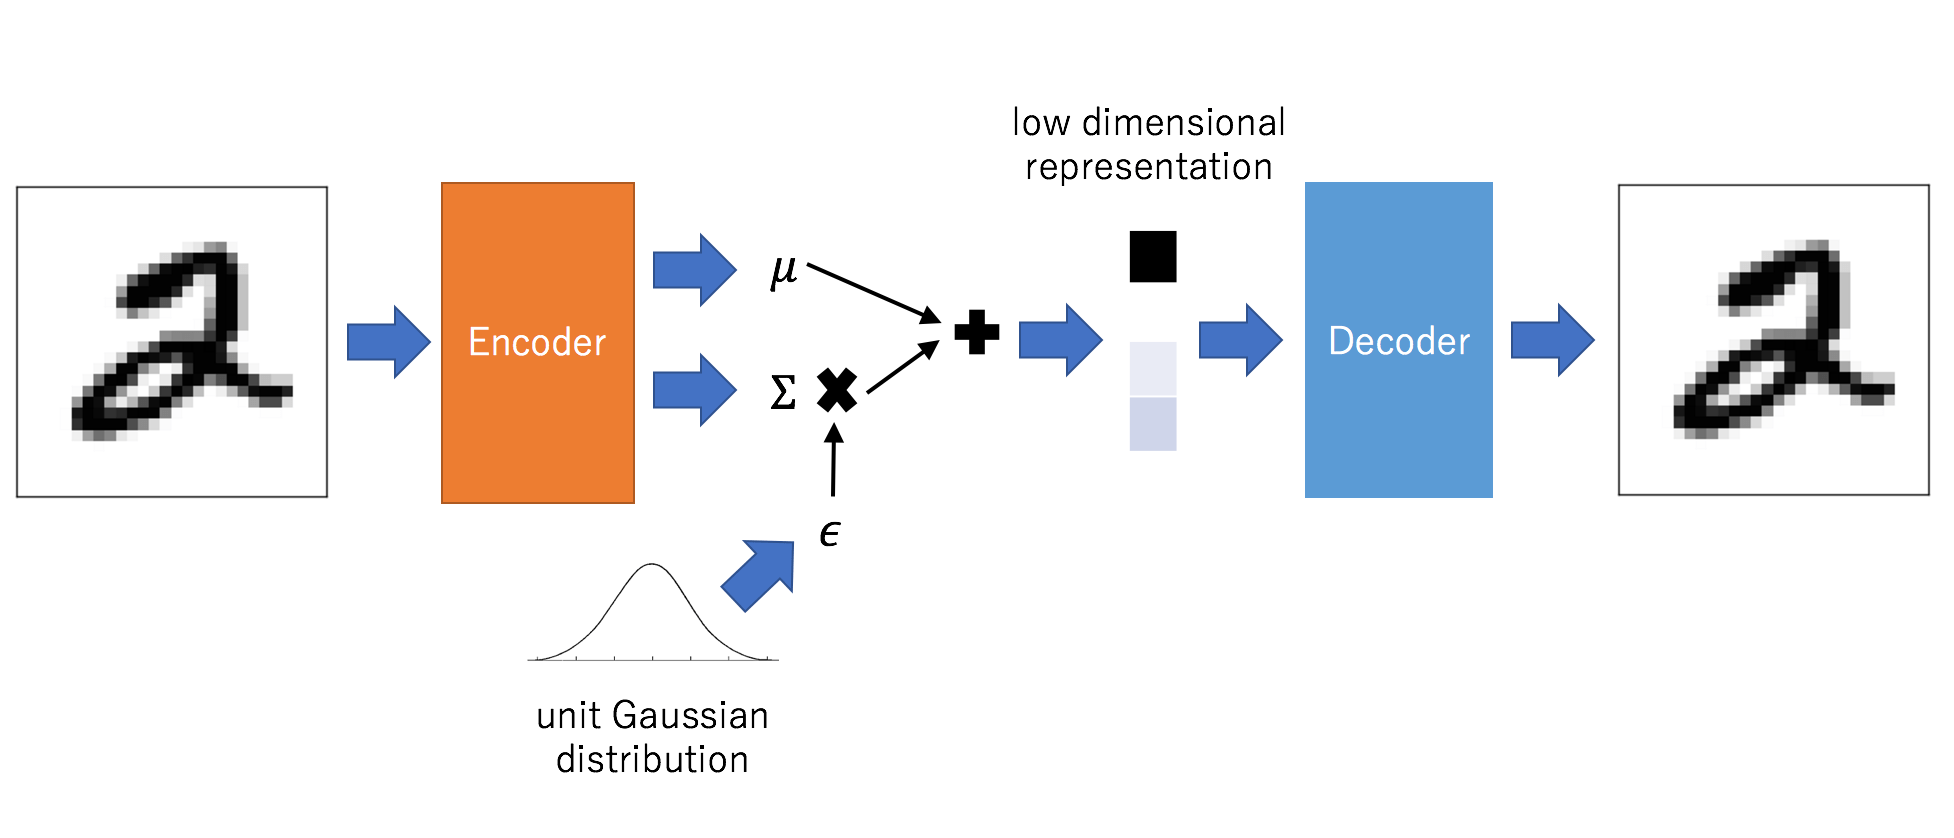
*(image source: https://mlexplained.com/2017/12/28/an-intuitive-explanation-of-variational-autoencoders-vaes-part-1)*

**By working on this problem you will learn and practice the following steps:**
1. Set up a data loading pipeline in PyTorch.
2. Implement, train and visualize an auto-encoder architecture.
3. Extend your implementation to a variational auto-encoder.
4. Learn how to tune the critical beta parameter of your VAE.
5. Inspect the learned representation of your VAE.
6. Extend VAE's generative capabilities by conditioning it on the label you wish to generate.


**Note**: For faster training of the models in this assignment you can enable GPU support in this Colab. Navigate to "Runtime" --> "Change Runtime Type" and set the "Hardware Accelerator" to "GPU". However, you might hit compute limits of the colab free edition. Hence, you might want to debug locally (e.g. in a jupyter notebook) or in a CPU-only runtime on colab.

# 1. MNIST Dataset

We will perform all experiments for this problem using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a standard dataset of handwritten digits. The main benefits of this dataset are that it is small and relatively easy to model. It therefore allows for quick experimentation and serves as initial test bed in many papers.

Another benefit is that it is so widely used that PyTorch even provides functionality to automatically download it.

Let's start by downloading the data and visualizing some samples.

In [4]:
import torch
import random
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
device = None
if torch.cuda.is_available():
    device = 'cuda:0'
# elif torch.backends.mps.is_available():
#     device = "mps"
else:
    device = "cpu"
    
device = torch.device(device)
print(f"Using device: {device}")


Using device: cpu


In [7]:

# this will automatically download the MNIST training set
mnist_train = torchvision.datasets.MNIST(root='./data', 
                                         train=True, 
                                         download=True, 
                                         transform=torchvision.transforms.ToTensor())
print("\n Download complete! Downloaded {} training examples!".format(len(mnist_train)))


 Download complete! Downloaded 60000 training examples!


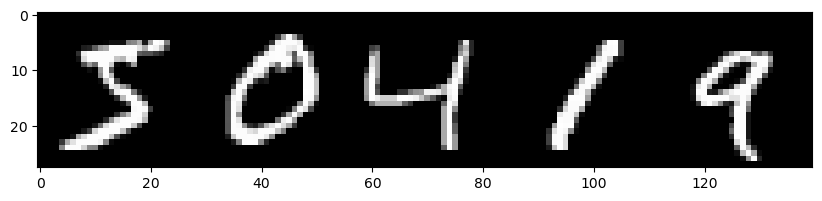

In [8]:
from numpy.random.mtrand import sample
import matplotlib.pyplot as plt
import numpy as np

# Let's display some of the training samples.
sample_images = []
randomize = False # set to False for debugging
num_samples = 5 # simple data sampling for now, later we will use proper DataLoader
if randomize:
  sample_idxs = np.random.randint(low=0,high=len(mnist_train), size=num_samples)
else:
  sample_idxs = list(range(num_samples))

for idx in sample_idxs:
  sample = mnist_train[idx]
  # print(f"Tensor w/ shape {sample[0][0].detach().cpu().numpy().shape} and label {sample[1]}")
  sample_images.append(sample[0][0].data.cpu().numpy())
  # print(sample_images[0]) # Values are in [0, 1]

fig = plt.figure(figsize = (10, 50))   
ax1 = plt.subplot(111)
ax1.imshow(np.concatenate(sample_images, axis=1), cmap='gray')
plt.show()

# 2. Auto-Encoder

Before implementing the full VAE, we will first implement an **auto-encoder architecture**. Auto-encoders feature the same encoder-decoder architecture as VAEs and therefore also learn a low-dimensional representation of the input data without supervision. In contrast to VAEs they are **fully deterministic** models and do not employ variational inference for optimization.

The **architecture** is very simple: we will encode the input image into a low-dimensional representation using fully connected layers for the encoder. This results in a low-dimensional representation of the input image. This representation will get decoded back into the dimensionality of the input image using a decoder network that mirrors the architecture of the encoder. The whole model is trained by **minimizing a reconstruction loss** between the input and the decoded image.

Intuitively, the **auto-encoder needs to compress the information contained in the input image** into a much lower dimensional representation (e.g. 28x28=784px vs. nz embedding dimensions for our MNIST model). This is possible since the information captured in the pixels is *highly redundant*. E.g. encoding an MNIST image requires <4 bits to encode which of the 10 possible digits is displayed and a few additional bits to capture information about shape and orientation. This is much less than the $255^{28\cdot 28}$ bits of information that could be theoretically captured in the input image.

Learning such a **compressed representation can make downstream task learning easier**. For example, learning to add two numbers based on the inferred digits is much easier than performing the task based on two piles of pixel values that depict the digits.

In the following, we will first define the architecture of encoder and decoder and then train the auto-encoder model.

## Defining the Auto-Encoder Architecture [6pt]

In [9]:
import torch.nn as nn

# Prob1-1: Let's define encoder and decoder networks
class Encoder(nn.Module):
  def __init__(self, nz, input_size):
    super().__init__()
    self.input_size = input_size
    self.net = nn.Sequential(
        nn.Linear(input_size, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, nz)
    )
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Encoder Architecture:                                                        #
    # - input_size -> 256                                                          #
    # - ReLU                                                                       #
    # - 256 -> 64                                                                  #
    # - ReLU                                                                       #
    # - 64 -> nz                                                                   #
    # HINT: Verify the shapes of intermediate layers by running partial networks   #
    #        (with the next notebook cell) and visualizing the output shapes.      #
    ################################################################################

    ################################ END TODO #######################################
  
  def forward(self, x):
    return self.net(x)


class Decoder(nn.Module):
  def __init__(self, nz, output_size):
    super().__init__()
    self.output_size = output_size
    self.net = nn.Sequential(
        nn.Linear(nz, 64),
        nn.ReLU(),
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, output_size),
        #nn.Sigmoid()
    )
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Decoder Architecture (mirrors encoder architecture):                         #
    # - nz -> 64                                                                   #
    # - ReLU                                                                       #
    # - 64 -> 256                                                                  #
    # - ReLU                                                                       #
    # - 256 -> output_size                                                         #
    ################################################################################

    ################################ END TODO #######################################
  
  def forward(self, z):
    return self.net(z).reshape(-1, 1, self.output_size)

## Testing the Auto-Encoder Forward Pass

In [10]:
# To test your encoder/decoder, let's encode/decode some sample images
# first, make a PyTorch DataLoader object to sample data batches
batch_size = 32
nworkers = 2        # number of workers used for efficient data loading

####################################################################################
# Create a PyTorch DataLoader object for efficiently generating training batches.  #
# Make sure that the data loader automatically shuffles the training dataset.      #
# Consider only *full* batches of data, to avoid torch errrors.              #
# The DataLoader wraps the MNIST dataset class we created earlier.           #
#       Use the given batch_size and number of data loading workers when creating  #
#       the DataLoader. https://pytorch.org/docs/stable/data.html                  #
####################################################################################
mnist_data_loader = torch.utils.data.DataLoader(mnist_train, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                num_workers=nworkers,
                                                drop_last=True)
####################################################################################

# now we can run a forward pass for encoder and decoder and check the produced shapes
in_size = out_size = 28*28 # image size
nz = 32          # dimensionality of the learned embedding
encoder = Encoder(nz=nz, input_size=in_size)
decoder = Decoder(nz=nz, output_size=out_size)
for sample_img, sample_label in mnist_data_loader: # loads a batch of data
  input = sample_img.reshape([batch_size, in_size])
  print(f'{sample_img.shape=}, {type(sample_img)}, {input.shape=}')
  enc = encoder(input)
  print(f"Shape of encoding vector (should be [batch_size, nz]): {enc.shape}")
  dec = decoder(enc)
  print("Shape of decoded image (should be [batch_size, 1, out_size]): {}.".format(dec.shape))    
  break

del input, enc, dec, encoder, decoder, nworkers # remove to avoid confusion later

sample_img.shape=torch.Size([32, 1, 28, 28]), <class 'torch.Tensor'>, input.shape=torch.Size([32, 784])
Shape of encoding vector (should be [batch_size, nz]): torch.Size([32, 32])
Shape of decoded image (should be [batch_size, 1, out_size]): torch.Size([32, 1, 784]).


Now that we defined encoder and decoder network our architecture is nearly complete. However, before we start training, we can wrap encoder and decoder into an auto-encoder class for easier handling.

In [11]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.encoder = Encoder(nz=nz, input_size=in_size)
    self.decoder = Decoder(nz=nz, output_size=out_size)

  def forward(self, x):
    enc = self.encoder(x)
    return self.decoder(enc)

  def reconstruct(self, x):
    """Only used later for visualization."""
    #sig = nn.Sigmoid()
    enc = self.encoder(x)
    flattened = self.decoder(enc)
    image = flattened.reshape(-1, 28, 28)
    return image

## Setting up the Auto-Encoder Training Loop [6pt]
After implementing the network architecture, we can now set up the training loop and run training.

In [35]:
# Prob1-2
epochs = 10
learning_rate = 1e-3

# build AE model
print(f'Device available {device}')
ae_model = AutoEncoder(nz).to(device)    # transfer model to GPU if available
ae_model = ae_model.train()   # set model in train mode (eg batchnorm params get updated)

from torch.optim import Adam
from torch.nn import BCELoss, MSELoss
# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer and loss classes. For the loss you can use a loss layer      #
# from the torch.nn package. We recommend binary cross entropy.                    #
# HINT: We will use the Adam optimizer (learning rate given above, otherwise       #
#       default parameters).                                                       #
# NOTE: We could also use alternative losses like MSE and cross entropy, depending #
#       on the assumptions we are making about the output distribution.            #
####################################################################################
optimizer = Adam(ae_model.parameters(), lr=learning_rate)
loss = MSELoss()
#################################### END TODO #######################################

train_it = 0
for ep in tqdm(range(epochs)):
    print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the auto-encoder model.                     #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the AE, compute the loss, perform the backward pass and    #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  ####################################################################################
    for train_it, (features, _) in enumerate(mnist_data_loader):
        features = torch.reshape(features, (features.size()[0], -1))
        features = features.to(device)
#        ground_truth = ground_truth.to(device)
        preds = ae_model(features).squeeze(1)
        #print('preds: min ',torch.min(preds),' max ',torch.max(preds),' features: min ',torch.min(features),' max ',torch.max(features))
        #print(features.size(),' ',ground_truth.size(),' ',preds.size())
        optimizer.zero_grad()
        rec_loss = loss(preds.squeeze(1), features)
        rec_loss.backward()
        optimizer.step()
        if train_it % 100 == 0:
          print("It {}: Reconstruction Loss: {}".format(train_it, rec_loss))
        train_it += 1
  #################################### END TODO #####################################

print("Done!")
del epochs, learning_rate, sample_img, train_it, rec_loss #, opt

Device available cpu


  0%|          | 0/10 [00:00<?, ?it/s]

Run Epoch 0
It 0: Reconstruction Loss: 0.12194009870290756
It 100: Reconstruction Loss: 0.04571395367383957
It 200: Reconstruction Loss: 0.034969478845596313
It 300: Reconstruction Loss: 0.03440478444099426
It 400: Reconstruction Loss: 0.029648274183273315
It 500: Reconstruction Loss: 0.028578918427228928
It 600: Reconstruction Loss: 0.02337622456252575
It 700: Reconstruction Loss: 0.023244081065058708
It 800: Reconstruction Loss: 0.025335242971777916
It 900: Reconstruction Loss: 0.02260671555995941
It 1000: Reconstruction Loss: 0.02458016760647297
It 1100: Reconstruction Loss: 0.025340892374515533
It 1200: Reconstruction Loss: 0.021840030327439308
It 1300: Reconstruction Loss: 0.02002537064254284
It 1400: Reconstruction Loss: 0.018480101600289345
It 1500: Reconstruction Loss: 0.019562767818570137
It 1600: Reconstruction Loss: 0.020438609644770622
It 1700: Reconstruction Loss: 0.017593013122677803
It 1800: Reconstruction Loss: 0.021866949275135994


 10%|█         | 1/10 [00:09<01:25,  9.53s/it]

Run Epoch 1
It 0: Reconstruction Loss: 0.019299739971756935
It 100: Reconstruction Loss: 0.018658429384231567
It 200: Reconstruction Loss: 0.01704474724829197
It 300: Reconstruction Loss: 0.01670641265809536
It 400: Reconstruction Loss: 0.018394634127616882
It 500: Reconstruction Loss: 0.018177665770053864
It 600: Reconstruction Loss: 0.01848546788096428
It 700: Reconstruction Loss: 0.01502065360546112
It 800: Reconstruction Loss: 0.016737716272473335
It 900: Reconstruction Loss: 0.014778116717934608
It 1000: Reconstruction Loss: 0.015838587656617165
It 1100: Reconstruction Loss: 0.01484092976897955
It 1200: Reconstruction Loss: 0.017944874241948128
It 1300: Reconstruction Loss: 0.015221658162772655
It 1400: Reconstruction Loss: 0.01733851432800293
It 1500: Reconstruction Loss: 0.014243419282138348
It 1600: Reconstruction Loss: 0.015178482048213482
It 1700: Reconstruction Loss: 0.015732167288661003
It 1800: Reconstruction Loss: 0.015363050624728203


 20%|██        | 2/10 [00:19<01:16,  9.60s/it]

Run Epoch 2
It 0: Reconstruction Loss: 0.01701890118420124
It 100: Reconstruction Loss: 0.014026133343577385
It 200: Reconstruction Loss: 0.01335265301167965
It 300: Reconstruction Loss: 0.015249845571815968
It 400: Reconstruction Loss: 0.014447645284235477
It 500: Reconstruction Loss: 0.014508379623293877
It 600: Reconstruction Loss: 0.014765311032533646
It 700: Reconstruction Loss: 0.014918223023414612
It 800: Reconstruction Loss: 0.014122962020337582
It 900: Reconstruction Loss: 0.012378874234855175
It 1000: Reconstruction Loss: 0.012403660453855991
It 1100: Reconstruction Loss: 0.014088832773268223
It 1200: Reconstruction Loss: 0.014797667972743511
It 1300: Reconstruction Loss: 0.014302151277661324
It 1400: Reconstruction Loss: 0.012426971457898617
It 1500: Reconstruction Loss: 0.013399393297731876
It 1600: Reconstruction Loss: 0.012995335273444653
It 1700: Reconstruction Loss: 0.01158975251019001
It 1800: Reconstruction Loss: 0.01405260618776083


 30%|███       | 3/10 [00:28<01:07,  9.59s/it]

Run Epoch 3
It 0: Reconstruction Loss: 0.012928057461977005
It 100: Reconstruction Loss: 0.014514721930027008
It 200: Reconstruction Loss: 0.01297493651509285
It 300: Reconstruction Loss: 0.014394463039934635
It 400: Reconstruction Loss: 0.015567283146083355
It 500: Reconstruction Loss: 0.013845665380358696
It 600: Reconstruction Loss: 0.012366844341158867
It 700: Reconstruction Loss: 0.014171062968671322
It 800: Reconstruction Loss: 0.01177985593676567
It 900: Reconstruction Loss: 0.015129141509532928
It 1000: Reconstruction Loss: 0.01284578163176775


 30%|███       | 3/10 [00:35<01:22, 11.81s/it]


KeyboardInterrupt: 

## Verifying reconstructions
Now that we trained the auto-encoder we can visualize some of the reconstructions on the test set to verify that it is converged and did not overfit. **Before continuing, make sure that your auto-encoder is able to reconstruct these samples near-perfectly.**

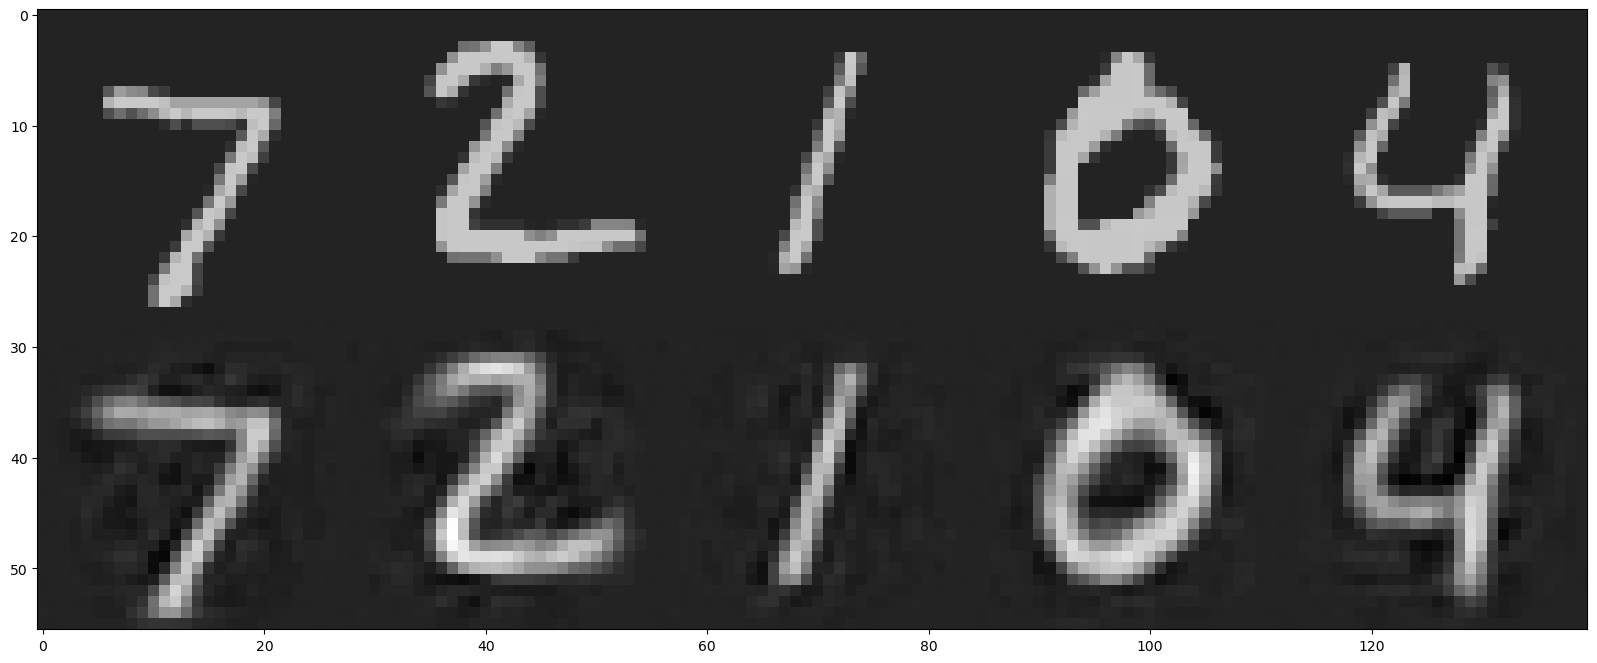

In [ ]:
# visualize test data reconstructions
def vis_reconstruction(model, randomize=False):
  # download MNIST test set + build Dataset object
  mnist_test = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          download=True, 
                                          transform=torchvision.transforms.ToTensor())
  model.eval()      # set model in evalidation mode (eg freeze batchnorm params)
  num_samples = 5
  if randomize:
    sample_idxs = np.random.randint(low=0,high=len(mnist_test), size=num_samples)
  else:
    sample_idxs = list(range(num_samples))

  input_imgs, test_reconstructions = [], []
  for idx in sample_idxs:
    sample = mnist_test[idx]
    input_img = np.asarray(sample[0])
    input_flat = input_img.reshape(784)
    #print(input_flat.min(),' ',input_flat.max())
    reconstruction = model.reconstruct(torch.tensor(input_flat, device=device))
    
    input_imgs.append(input_img[0])
    test_reconstructions.append(reconstruction[0].data.cpu().numpy())
    # print(f'{input_img[0].shape=}\t{reconstruction.shape}')

  fig = plt.figure(figsize = (20, 50))   
  ax1 = plt.subplot(111)
  ax1.imshow(np.concatenate([np.concatenate(input_imgs, axis=1),
                            np.concatenate(test_reconstructions, axis=1)], axis=0), cmap='gray')
  plt.show()

vis_reconstruction(ae_model, randomize=False) # set randomize to False for debugging

## Sampling from the Auto-Encoder [2pt]

To test whether the auto-encoder is useful as a generative model, we can use it like any other generative model: draw embedding samples from a prior distribution and decode them through the decoder network. We will choose a unit Gaussian prior to allow for easy comparison to the VAE later.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 28, 28])
(3, 122, 122)


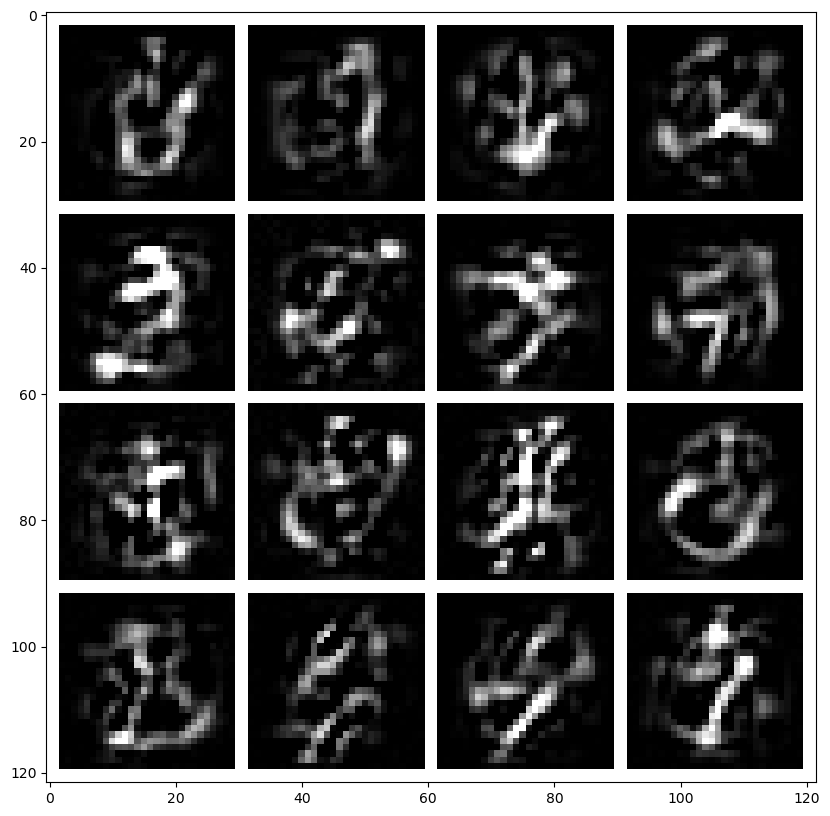

In [ ]:
# we will sample N embeddings, then decode and visualize them
import numpy as np
def vis_samples(model):
    #cov = [[0]*nz for i in range(nz)]
  ####################################### TODO #######################################
  # Prob1-3 Sample embeddings from a diagonal unit Gaussian distribution and decode them     #
  # using the model.                                                                 #
  # HINT: The sampled embeddings should have shape [batch_size, nz]. Diagonal unit   #
  #       Gaussians have mean 0 and a covariance matrix with ones on the diagonal    #
  #       and zeros everywhere else.                                                 #
  # HINT: If you are unsure whether you sampled the correct distribution, you can    #
  #       sample a large batch and compute the empirical mean and variance using the #
  #       .mean() and .var() functions.                                              #
  # HINT: You can directly use model.decoder() to decode the samples.                #
  ####################################################################################
#     mean = [0]*nz
#     cov = list()
#     for i in range(nz):
#         temp = [0]*nz
#         temp[i]=1
#         cov.append(temp)
#     embeddings = np.random.multivariate_normal(mean, cov, 1000)
#     print(embeddings.shape,' ',np.mean(embeddings),' ',np.var(embeddings))
#     embeddings = torch.from_numpy(embeddings).to(device).to(torch.float32)
#     decoded_samples = model.decoder(embeddings)
#     print(decoded_samples.shape)
#     decoded_samples = torch.reshape(decoded_samples, (-1, 1, 28, 28))#.permute(1,2,0)
#     print(decoded_samples.shape)
    #sig = nn.Sigmoid()
    embeddings = torch.empty((batch_size, nz)).normal_()
    decoded_samples = model.decoder(embeddings).reshape(-1,1,28,28)
    print(decoded_samples.size())
  #################################### END TODO ######################################

    fig = plt.figure(figsize = (10, 10))   
    ax1 = plt.subplot(111)
    print(torchvision.utils.make_grid(decoded_samples[:16], nrow=4, pad_value=1.)\
                .data.cpu().numpy().shape)
    ax1.imshow(torchvision.utils.make_grid(decoded_samples[:16], nrow=4, pad_value=1.)\
                .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
    plt.show()

vis_samples(ae_model)
#del ae_model


>**Prob1-3 continued: Inline Question: Describe your observations, why do you think they occur? [2pt]** 
>(max 150 words)
>
>**Answer:** The encoder decoder structure is encoder-vector-decoder where vector size is less than the input size. However here we are using decoder from the vector of same shape as the one that is in between encoder and decoder, and the vector is initialized with mean 0 and var 1. However when the network was trained end-to-end the decoder that observed the compressed vector may have a completely different mean and variance, as a result it was trained to generate sensible output upon the vector with those particular mean and variance. Hence the decoder doesn't give sensible results at all from the vector with mean 0 and variance as 1.



# 3. Variational Auto-Encoder (VAE)

Variational auto-encoders use a very similar architecture to deterministic auto-encoders, but are inherently storchastic models, i.e. we perform a stochastic sampling operation during the forward pass, leading to different different outputs every time we run the network for the same input. This sampling is required to optimize the VAE objective also known as the evidence lower bound (ELBO):

$$
p(x) > \underbrace{\mathbb{E}_{z\sim q(z\vert x)} p(x \vert z)}_{\text{reconstruction}} - \underbrace{D_{\text{KL}}\big(q(z \vert x), p(z)\big)}_{\text{prior divergence}}
$$

Here, $D_{\text{KL}}(q, p)$ denotes the Kullback-Leibler (KL) divergence between the posterior distribution $q(z \vert x)$, i.e. the output of our encoder, and $p(z)$, the prior over the embedding variable $z$, which we can choose freely.

For simplicity, we will choose a unit Gaussian prior again. The first term is the reconstruction term we already know from training the auto-encoder. When assuming a Gaussian output distribution for both encoder $q(z \vert x)$ and decoder $p(x \vert z)$ the objective reduces to:

$$
\mathcal{L}_{\text{VAE}} = \sum_{x\sim \mathcal{D}} \mathcal{L}_{\text{rec}}(x, \hat{x}) - \beta \cdot D_{\text{KL}}\big(\mathcal{N}(\mu_q, \sigma_q), \mathcal{N}(0, I)\big)
$$

Here, $\hat{x}$ is the reconstruction output of the decoder. In comparison to the auto-encoder objective, the VAE adds a regularizing term between the output of the encoder and a chosen prior distribution, effectively forcing the encoder output to not stray too far from the prior during training. As a result the decoder gets trained with samples that look pretty similar to samples from the prior, which will hopefully allow us to generate better images when using the VAE as a generative model and actually feeding it samples from the prior (as we have done for the AE before).

The coefficient $\beta$ is a scalar weighting factor that trades off between reconstruction and regularization objective. We will investigate the influence of this factor in out experiments below.

If you need a refresher on VAEs you can check out this tutorial paper: https://arxiv.org/abs/1606.05908

### Reparametrization Trick

The sampling procedure inside the VAE's forward pass for obtaining a sample $z$ from the posterior distribution $q(z \vert x)$, when implemented naively, is non-differentiable. However, since $q(z\vert x)$ is parametrized with a Gaussian function, there is a simple trick to obtain a differentiable sampling operator, known as the _reparametrization trick_.

Instead of directly sampling $z \sim \mathcal{N}(\mu_q, \sigma_q)$ we can "separate" the network's predictions and the random sampling by computing the sample as:

$$
z = \mu_q + \sigma_q * \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)
$$

Note that in this equation, the sample $z$ is computed as a deterministic function of the network's predictions $\mu_q$ and $\sigma_q$ and therefore allows to propagate gradients through the sampling procedure.

**Note**: While in the equations above the encoder network parametrizes the standard deviation $\sigma_q$ of the Gaussian posterior distribution, in practice we usually parametrize the **logarithm of the standard deviation** $\log \sigma_q$ for numerical stability. Before sampling $z$ we will then exponentiate the network's output to obtain $\sigma_q$.



## Defining the VAE Model [7pt]

In [12]:
def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  """Computes KL[p||q] between two Gaussians defined by [mu, log_sigma]."""
  return (log_sigma2 - log_sigma1) + (torch.exp(log_sigma1) ** 2 + (mu1 - mu2) ** 2) \
               / (2 * torch.exp(log_sigma2) ** 2) - 0.5

# Prob1-4
class VAE(nn.Module):
    def __init__(self, nz, beta=1.0):
        super().__init__()
        self.nz = nz
        self.beta = beta          # factor trading off between two loss components
        ####################################### TODO #######################################
        # Instantiate Encoder and Decoder.                                                 #
        # HINT: Remember that the encoder is now parametrizing a Gaussian distribution's   #
        #       mean and log_sigma, so the dimensionality of the output needs to           #
        #       double. The decoder works with an embedding sampled from this output.  #
        ####################################################################################
        self.encoder=Encoder(nz=2*nz, input_size=in_size)
        self.decoder=Decoder(nz=nz, output_size=out_size)
        #################################### END TODO ######################################

    def reparameterise(self, mean, std):
        #eps = torch.randn_like(std)
        #eps = torch.empty_like(std).normal_()
        eps = std.data.new(std.size()).normal_()
        return mean + eps*torch.exp(std)
    
    def forward(self, x):
        ####################################### TODO #######################################
        # Implement the forward pass of the VAE.                                           #
        # HINT: Your code should implement the following steps:                            #
        #          1. encode input x, split encoding into mean and log_sigma of Gaussian   #
        #          2. sample z from inferred posterior distribution using                  #
        #             reparametrization trick                                              #
        #          3. decode the sampled z to obtain the reconstructed image               #
        ####################################################################################
        #print("x.shape ", x.shape)
        q = self.encoder(x)
        #print("after encoder" , q.shape)
        q = q.view(-1, 2, self.nz)
        #print("after reshape", q.shape)

        self.mean = q[:, 0, :]
        self.std = q[:, 1, :]
        #print("mean/std", self.mean.shape, self.std.shape)
        q = self.reparameterise(self.mean, self.std)
        print("q.shape", q.shape)
        reconstruction = self.decoder(q)
        
        #################################### END TODO ######################################

        return {'q': q, 
                'rec': reconstruction}

    def loss(self, x, outputs):
        ####################################### TODO #######################################
        # Implement the loss computation of the VAE.                                       #
        # HINT: Your code should implement the following steps:                            #
        #          1. compute the image reconstruction loss, similar to AE loss above      #
        #          2. compute the KL divergence loss between the inferred posterior        #
        #             distribution and a unit Gaussian prior; you can use the provided     #
        #             function above for computing the KL divergence between two Gaussians #
        #             parametrized by mean and log_sigma                                   #
        # HINT: Make sure to compute the KL divergence in the correct order since it is    #
        #       not symmetric!!  ie. KL(p, q) != KL(q, p)                                  #
        ####################################################################################
        #print('x ',x,' out ',outputs)
        x = x.unsqueeze(1)
        loss_mse = nn.MSELoss()
        #print(outputs['rec'].size(),' ',x.size(),' ',outputs['q'].size())
        rec_loss = loss_mse(outputs['rec'], x)#torch.square(x-outputs).mean() 
        mean_and_std = outputs['q'].view(-1, 2, self.nz)
        mean1 = mean_and_std[:,0,:]
        std1 = mean_and_std[:,1,:]
        kl_loss = kl_divergence(mean1, std1, torch.zeros_like(mean1), torch.zeros_like(std1)).mean()
        #################################### END TODO ######################################

        # return weighted objective
        #print('rec loss ',rec_loss,' kl_loss ',kl_loss)
        return rec_loss + self.beta * kl_loss, \
               {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
    def reconstruct(self, x):
        """Use mean of posterior estimate for visualization reconstruction."""
        ####################################### TODO #######################################
        # This function is used for visualizing reconstructions of our VAE model. To       #
        # obtain the maximum likelihood estimate we bypass the sampling procedure of the   #
        # inferred latent and instead directly use the mean of the inferred posterior.     #
        # HINT: encode the input image and then decode the mean of the posterior to obtain #
        #       the reconstruction.                                                        #
        ####################################################################################
        #sigmoid = nn.Sigmoid()
        q = self.encoder(x)
        q = q.view(-1, 2, self.nz)
        mean = q[:, 0, :]
        image = self.decoder(mean)

        #################################### END TODO ######################################
        return image.reshape(-1, 28,28)


## Setting up the VAE Training Loop [4pt]

Let's start training the VAE model! We will first verify our implementation by setting $\beta = 0$.


In [13]:
# Prob1-5 VAE training loop
learning_rate = 1e-3
nz = 32
beta = 0

####################################### TODO #######################################
epochs = 20      # recommended 5-20 epochs
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
from torch.optim import Adam
optimizer = Adam(vae_model.parameters(), lr=learning_rate)
# same as AE
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the VAE model.                              #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the VAE, compute the loss, perform the backward pass and   #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  # HINT: This time we will use the loss() function of our model for computing the   #
  #       training loss. It outputs the total training loss and a dict containing    #
  #       the breakdown of reconstruction and KL loss.                               #
  ####################################################################################
  for train_it, (features, _) in enumerate(mnist_data_loader):
    features = torch.reshape(features, (features.size()[0], -1))
    features = features.to(device)
    #print("features ", features.size())
    optimizer.zero_grad()
    q_reconstruction = vae_model(features)
    #import pdb;pdb.set_trace()
    total_loss, losses = vae_model.loss(features, q_reconstruction)
    rec_loss.append(losses['rec_loss'].detach()); kl_loss.append(losses['kl_loss'].detach())
    total_loss.backward()
    optimizer.step()
    #print(losses['rec_loss'], losses['kl_loss'])
    if train_it % 100 == 0:
        print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
               .format(train_it, total_loss.detach().item(), losses['rec_loss'].item(), losses['kl_loss'].item()))
    #print('It ',train_it,' : Total Loss: ',total_loss.detach().item(),', \t Rec Loss: ',losses['rec_loss'].item(),', \t KL Loss: ',losses['kl_loss'].item())
    #train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

Running 20 epochs with beta=0
Run Epoch 0
q.shape torch.Size([32, 32])
It 0: Total Loss: 0.12455850094556808, 	 Rec Loss: 0.12455850094556808,	 KL Loss: 132.0420379638672
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Size([32, 32])
q.shape torch.Siz

KeyboardInterrupt: 

Let's look at some reconstructions and decoded embedding samples!

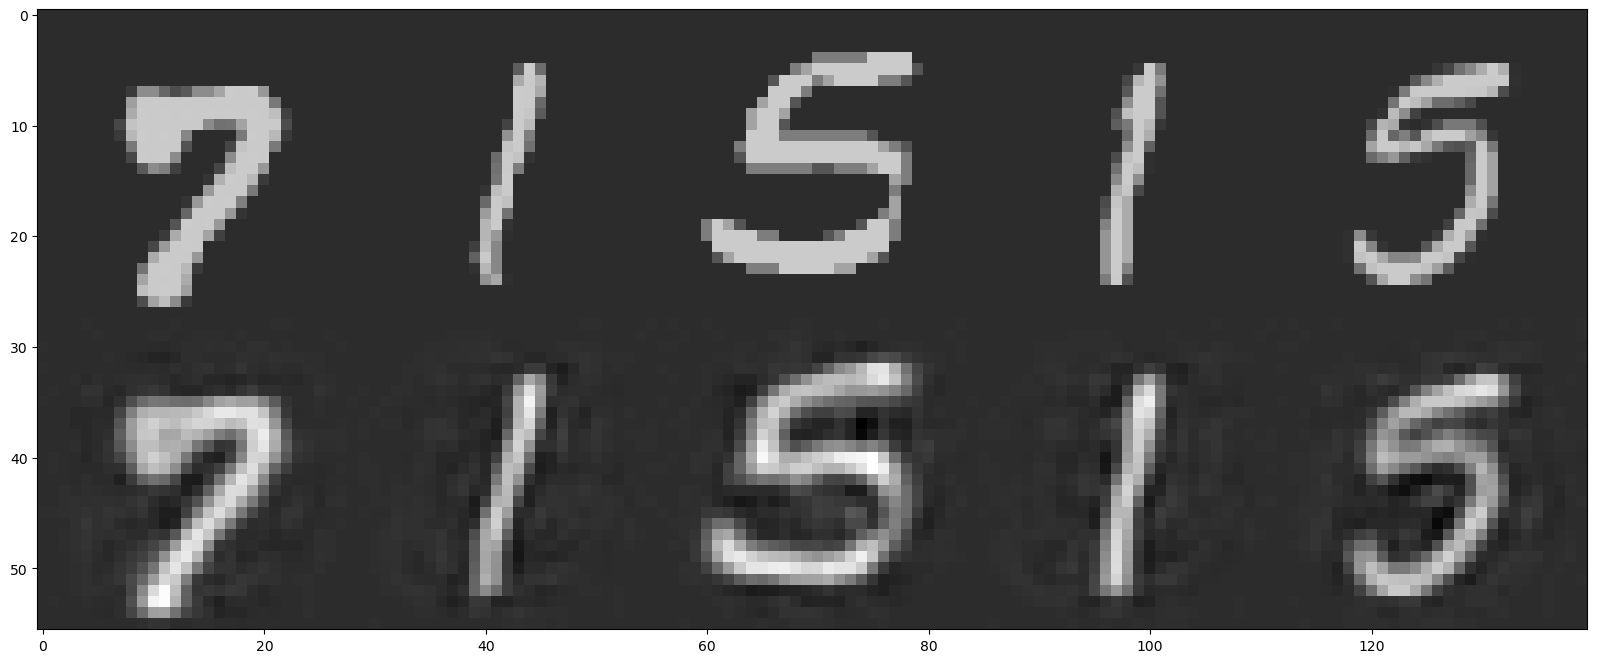

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 1, 28, 28])
(3, 122, 122)


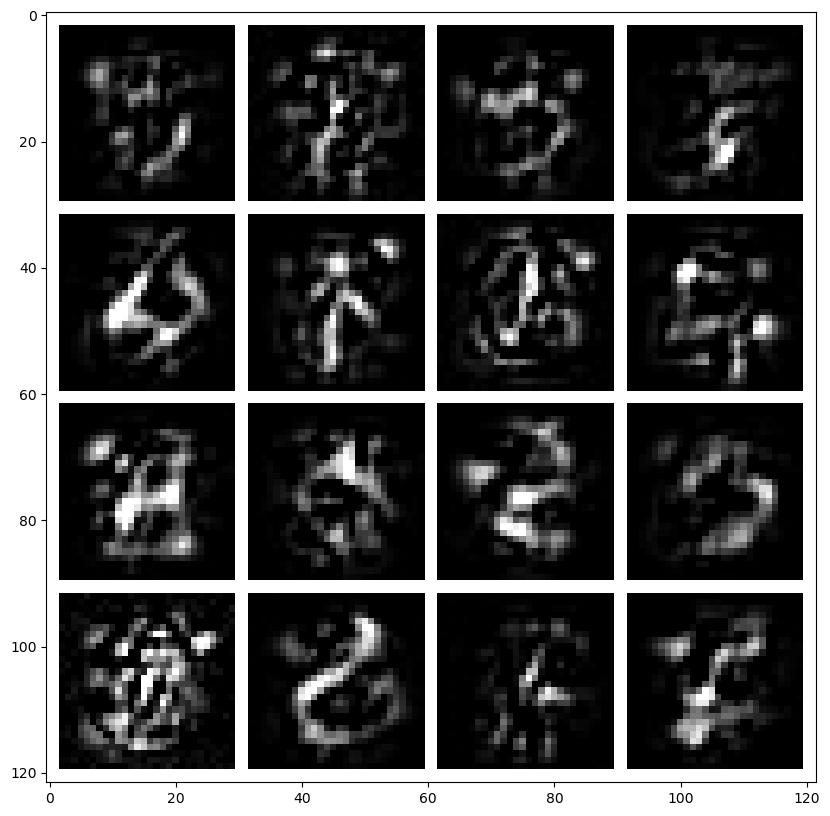

In [ ]:
# visualize VAE reconstructions and samples from the generative model
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

## Tweaking the loss function $\beta$ [2pt]
Prob1-6: Let's repeat the same experiment for $\beta = 10$, a very high value for the coefficient.

In [ ]:
# VAE training loop
#beta = 0.008 #not so good as KL partially shoots
#beta = 0.01 #
#beta = 0.001 very bad kl shoots
learning_rate = 1e-3
nz = 32
beta = 10

####################################### TODO #######################################
epochs = 5      # recommended 5-20 epochs
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
optimizer = Adam(vae_model.parameters(), lr=learning_rate)
# same as AE
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the VAE model.                              #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the VAE, compute the loss, perform the backward pass and   #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  # HINT: This time we will use the loss() function of our model for computing the   #
  #       training loss. It outputs the total training loss and a dict containing    #
  #       the breakdown of reconstruction and KL loss.                               #
  ####################################################################################
  for train_it, (features, _) in enumerate(mnist_data_loader):
    features = torch.reshape(features, (features.size()[0], -1))
    features = features.to(device)
    #print(features.size())
    optimizer.zero_grad()
    q_reconstruction = vae_model(features)
    total_loss, losses = vae_model.loss(features, q_reconstruction)
    rec_loss.append(losses['rec_loss'].detach()); kl_loss.append(losses['kl_loss'].detach())
    total_loss.backward()
    optimizer.step()

    if train_it % 100 == 0:
      print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
            .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
    train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

Running 5 epochs with beta=10
Run Epoch 0
It 0: Total Loss: 1107.533203125, 	 Rec Loss: 0.11927814781665802,	 KL Loss: 110.74139404296875
It 100: Total Loss: 3.253089427947998, 	 Rec Loss: 0.07107163220643997,	 KL Loss: 0.31820178031921387
It 200: Total Loss: 0.8321793675422668, 	 Rec Loss: 0.061007432639598846,	 KL Loss: 0.0771171897649765
It 300: Total Loss: 0.47638171911239624, 	 Rec Loss: 0.06347408145666122,	 KL Loss: 0.0412907637655735
It 400: Total Loss: 0.3821154236793518, 	 Rec Loss: 0.0667627826333046,	 KL Loss: 0.03153526410460472
It 500: Total Loss: 0.3216662108898163, 	 Rec Loss: 0.06051424518227577,	 KL Loss: 0.02611519768834114
It 600: Total Loss: 0.3671260476112366, 	 Rec Loss: 0.06710560619831085,	 KL Loss: 0.030002042651176453
It 700: Total Loss: 0.3260333240032196, 	 Rec Loss: 0.0609944686293602,	 KL Loss: 0.02650388330221176
It 800: Total Loss: 0.26429909467697144, 	 Rec Loss: 0.059920698404312134,	 KL Loss: 0.02043784037232399
It 900: Total Loss: 0.3058158457279205

KeyboardInterrupt: 

>**Inline Question: What can you observe when setting $\beta = 0$ and $\beta = 10$? Explain your observations! [2pt]** 
>(max 200 words) 
>
>**Answer**:

## Obtaining the best $\beta$-factor [5pt]
Prob 1-6 continued: Now we can start tuning the beta value to achieve a good result. First describe what a "good result" would look like (focus what you would expect for reconstructions and sample quality). 

>**Inline Question: Characterize what properties you would expect for reconstructions and samples of a well-tuned VAE! [3pt]**
>(max 200 words)
>
>**Answer**: 
>

Now that you know what outcome we would like to obtain, try to tune $\beta$ to achieve this result. Logarithmic search in steps of 10x will be helpful, good results can be achieved after ~20 epochs of training. Training reconstructions should be high quality, test samples should be diverse, distinguishable numbers, most samples recognizable as numbers.

**Answer: Tuned beta value _______ [2pt]**

Running 20 epochs with beta=0.05
Run Epoch 0
It 0: Total Loss: 7.285377502441406, 	 Rec Loss: 0.13463515043258667,	 KL Loss: 143.0148468017578
It 100: Total Loss: 0.08549243956804276, 	 Rec Loss: 0.0673152431845665,	 KL Loss: 0.36354395747184753
It 200: Total Loss: 0.0665467157959938, 	 Rec Loss: 0.06348167359828949,	 KL Loss: 0.06130078807473183
It 300: Total Loss: 0.06339606642723083, 	 Rec Loss: 0.058656249195337296,	 KL Loss: 0.0947963073849678
It 400: Total Loss: 0.061101287603378296, 	 Rec Loss: 0.0585596077144146,	 KL Loss: 0.05083363503217697
It 500: Total Loss: 0.05366087704896927, 	 Rec Loss: 0.051209963858127594,	 KL Loss: 0.0490182526409626
It 600: Total Loss: 0.05657221004366875, 	 Rec Loss: 0.05281960219144821,	 KL Loss: 0.07505214214324951
It 700: Total Loss: 0.048457805067300797, 	 Rec Loss: 0.04529258608818054,	 KL Loss: 0.06330439448356628
It 800: Total Loss: 0.04860416799783707, 	 Rec Loss: 0.04546388238668442,	 KL Loss: 0.06280567497015
It 900: Total Loss: 0.0506849

It 200: Total Loss: 0.020625678822398186, 	 Rec Loss: 0.019305100664496422,	 KL Loss: 0.026411574333906174
It 300: Total Loss: 0.020106088370084763, 	 Rec Loss: 0.01872100494801998,	 KL Loss: 0.02770167961716652
It 400: Total Loss: 0.0210602805018425, 	 Rec Loss: 0.019657084718346596,	 KL Loss: 0.028063904494047165
It 500: Total Loss: 0.02172621339559555, 	 Rec Loss: 0.02037092112004757,	 KL Loss: 0.02710585668683052
It 600: Total Loss: 0.020763278007507324, 	 Rec Loss: 0.01945922151207924,	 KL Loss: 0.026081126183271408
It 700: Total Loss: 0.021693050861358643, 	 Rec Loss: 0.020293012261390686,	 KL Loss: 0.028000786900520325
It 800: Total Loss: 0.019954878836870193, 	 Rec Loss: 0.01848282478749752,	 KL Loss: 0.02944108471274376
It 900: Total Loss: 0.020766451954841614, 	 Rec Loss: 0.01937696523964405,	 KL Loss: 0.02778971567749977
It 1000: Total Loss: 0.020047899335622787, 	 Rec Loss: 0.018874557688832283,	 KL Loss: 0.02346682921051979
It 1100: Total Loss: 0.018735520541667938, 	 Rec 

It 300: Total Loss: 0.01642606221139431, 	 Rec Loss: 0.015676531940698624,	 KL Loss: 0.014990601688623428
It 400: Total Loss: 0.01834985241293907, 	 Rec Loss: 0.017620911821722984,	 KL Loss: 0.014578796923160553
It 500: Total Loss: 0.0160293560475111, 	 Rec Loss: 0.015347225591540337,	 KL Loss: 0.013642624020576477
It 600: Total Loss: 0.019008157774806023, 	 Rec Loss: 0.01829337514936924,	 KL Loss: 0.014295637607574463
It 700: Total Loss: 0.014420882798731327, 	 Rec Loss: 0.013787769712507725,	 KL Loss: 0.012662265449762344
It 800: Total Loss: 0.01671595312654972, 	 Rec Loss: 0.01603691093623638,	 KL Loss: 0.013580843806266785
It 900: Total Loss: 0.016309009864926338, 	 Rec Loss: 0.015624276362359524,	 KL Loss: 0.013694673776626587
It 1000: Total Loss: 0.017490722239017487, 	 Rec Loss: 0.01680552028119564,	 KL Loss: 0.013704057782888412
It 1100: Total Loss: 0.01754998415708542, 	 Rec Loss: 0.016880711540579796,	 KL Loss: 0.013385433703660965
It 1200: Total Loss: 0.016399607062339783, 	

It 400: Total Loss: 0.01680581644177437, 	 Rec Loss: 0.016308799386024475,	 KL Loss: 0.009940333664417267
It 500: Total Loss: 0.01409012358635664, 	 Rec Loss: 0.01359574869275093,	 KL Loss: 0.009887490421533585
It 600: Total Loss: 0.014654035679996014, 	 Rec Loss: 0.014169863425195217,	 KL Loss: 0.009683441370725632
It 700: Total Loss: 0.015927596017718315, 	 Rec Loss: 0.01544963102787733,	 KL Loss: 0.009559296071529388
It 800: Total Loss: 0.01537255197763443, 	 Rec Loss: 0.01494606863707304,	 KL Loss: 0.008529674261808395
It 900: Total Loss: 0.012632523663341999, 	 Rec Loss: 0.012197982519865036,	 KL Loss: 0.008690815418958664
It 1000: Total Loss: 0.012559434399008751, 	 Rec Loss: 0.012134901247918606,	 KL Loss: 0.0084906704723835
It 1100: Total Loss: 0.01494642999023199, 	 Rec Loss: 0.01448261272162199,	 KL Loss: 0.009276345372200012
It 1200: Total Loss: 0.014840137213468552, 	 Rec Loss: 0.0143671166151762,	 KL Loss: 0.009460419416427612
It 1300: Total Loss: 0.013715891167521477, 	 R

It 500: Total Loss: 0.013692788779735565, 	 Rec Loss: 0.013330555520951748,	 KL Loss: 0.007244661450386047
It 600: Total Loss: 0.013816672377288342, 	 Rec Loss: 0.01346332486718893,	 KL Loss: 0.007066953927278519
It 700: Total Loss: 0.013537784107029438, 	 Rec Loss: 0.013168171979486942,	 KL Loss: 0.0073922425508499146
It 800: Total Loss: 0.014602907001972198, 	 Rec Loss: 0.014247672632336617,	 KL Loss: 0.007104694843292236
It 900: Total Loss: 0.013387280516326427, 	 Rec Loss: 0.01301201619207859,	 KL Loss: 0.007505286484956741
It 1000: Total Loss: 0.015153111889958382, 	 Rec Loss: 0.014794374816119671,	 KL Loss: 0.007174737751483917
It 1100: Total Loss: 0.012778227217495441, 	 Rec Loss: 0.012445056810975075,	 KL Loss: 0.006663411855697632
It 1200: Total Loss: 0.014789829030632973, 	 Rec Loss: 0.014436891302466393,	 KL Loss: 0.007058747112751007
It 1300: Total Loss: 0.014224991202354431, 	 Rec Loss: 0.01384703814983368,	 KL Loss: 0.0075590647757053375
It 1400: Total Loss: 0.01434354670

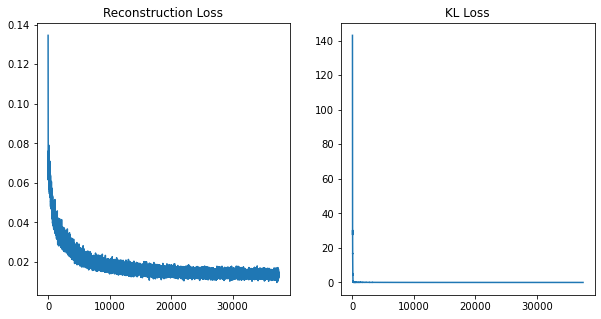

In [ ]:
# Tuning for best beta
learning_rate = 1e-3
nz = 32

####################################### TODO #######################################
epochs = 20     # recommended 5-20 epochs
#beta = 0.001 # Tune this for best results
beta = 0.05
#beta = 1
#################################### END TODO ######################################

# build VAE model
vae_model = VAE(nz, beta).to(device)    # transfer model to GPU if available
vae_model = vae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the vae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
optimizer = Adam(vae_model.parameters(), lr=learning_rate)
# same as AE
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  ####################################### TODO #######################################
  # Implement the main training loop for the VAE model.                              #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the VAE, compute the loss, perform the backward pass and   #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  # HINT: This time we will use the loss() function of our model for computing the   #
  #       training loss. It outputs the total training loss and a dict containing    #
  #       the breakdown of reconstruction and KL loss.                               #
  ####################################################################################
  for train_it, (features, _) in enumerate(mnist_data_loader):
    features = torch.reshape(features, (features.size()[0], -1))
    features = features.to(device)
    #print(features.size())
    optimizer.zero_grad()
    q_reconstruction = vae_model(features)
    total_loss, losses = vae_model.loss(features, q_reconstruction)
    rec_loss.append(losses['rec_loss'].detach()); kl_loss.append(losses['kl_loss'].detach())
    total_loss.backward()
    optimizer.step()
    if train_it % 100 == 0:
      print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
            .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
    train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))   
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

# 4. Embedding Space Interpolation [3pt]

As mentioned in the introduction, AEs and VAEs cannot only be used to generate images, but also to learn low-dimensional representations of their inputs. In this final section we will investigate the representations we learned with both models by **interpolating in embedding space** between different images. We will encode two images into their low-dimensional embedding representations, then interpolate these embeddings and reconstruct the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


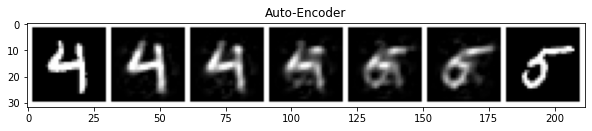

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


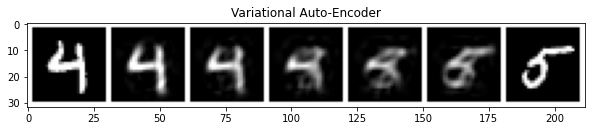

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


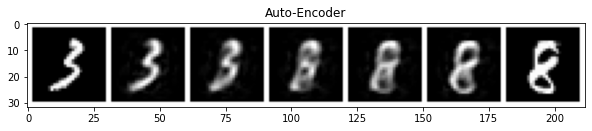

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


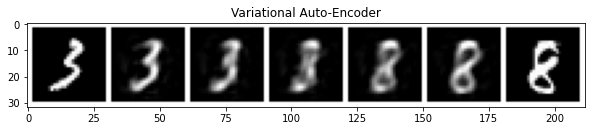

In [ ]:
# Prob1-7
nz=32

def get_image_with_label(target_label):
  """Returns a random image from the training set with the requested digit."""
  for img_batch, label_batch in mnist_data_loader:
    for img, label in zip(img_batch, label_batch):
      if label == target_label:
        return img.to(device)

def interpolate_and_visualize(model, tag, start_img, end_img):
  """Encodes images and performs interpolation. Displays decodings."""
  model.eval()    # put model in eval mode to avoid updating batchnorm

  # encode both images into embeddings (use posterior mean for interpolation)
  z_start = model.encoder(start_img[None].reshape(1,784))[..., :nz]
  z_end = model.encoder(end_img[None].reshape(1,784))[..., :nz]

  # compute interpolated latents
  N_INTER_STEPS = 5
  z_inter = [z_start + i/N_INTER_STEPS * (z_end - z_start) for i in range(N_INTER_STEPS)]

  # decode interpolated embeddings (as a single batch)
  img_inter = model.decoder(torch.cat(z_inter))
  img_inter = img_inter.reshape(-1, 28, 28)

  # reshape result and display interpolation
  vis_imgs = torch.cat([start_img, img_inter, end_img]).reshape(-1,1,28,28)
  fig = plt.figure(figsize = (10, 10))   
  ax1 = plt.subplot(111)
  ax1.imshow(torchvision.utils.make_grid(vis_imgs, nrow=N_INTER_STEPS+2, pad_value=1.)\
                  .data.cpu().numpy().transpose(1, 2, 0), cmap='gray')
  plt.title(tag)
  plt.show()


### Interpolation 1
START_LABEL = 4# ... TODO CHOOSE
END_LABEL = 5# ... TODO CHOOSE
# sample two training images with given labels
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)
# visualize interpolations for AE and VAE models
interpolate_and_visualize(ae_model, "Auto-Encoder", start_img, end_img)
interpolate_and_visualize(vae_model, "Variational Auto-Encoder", start_img, end_img)

### Interpolation 2
START_LABEL = 3 # ... TODO CHOOSE
END_LABEL = 8# ... TODO CHOOSE
# sample two training images with given labels
start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)
# visualize interpolations for AE and VAE models
interpolate_and_visualize(ae_model, "Auto-Encoder", start_img, end_img)
interpolate_and_visualize(vae_model, "Variational Auto-Encoder", start_img, end_img)


Repeat the experiment for different start / end labels and different samples. Describe your observations.

>**Prob1-7 continued: Inline Question: Repeat the interpolation experiment with different start / end labels and multiple samples. Describe your observations! [2 pt]**
>  1. How do AE and VAE embedding space interpolations differ?
>  2. How do you expect these differences to affect the usefulness of the learned representation for downstream learning?
>(max 300 words)
>
>**Answer**:
>

# 5. Conditional VAE
Let us now try a Conditional VAE
Now we will try to create a [Conditional VAE](https://proceedings.neurips.cc/paper/2014/file/d523773c6b194f37b938d340d5d02232-Paper.pdf), where we can condition the encoder and decoder of the VAE on the label `c`. 

## Defining the conditional Encoder, Decoder, and VAE models [5 pt]

Prob1-8. We create a separate encoder and decoder class that take in an additional argument `c` in their forward pass, and then build our CVAE model on top of it. Note that the encoder and decoder just need to append `c` to the standard inputs to these modules.

In [ ]:
def idx2onehot(idx, n):
    """Converts a batch of indices to a one-hot representation."""
    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)

    return onehot

# Let's define encoder and decoder networks

class CVAEEncoder(nn.Module):
  def __init__(self, nz, input_size, conditional, num_labels):
    super().__init__()
    self.input_size = input_size + num_labels if conditional else input_size
    self.num_labels = num_labels
    self.conditional = conditional
    self.nz = nz
    
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Encoder Architecture:                                                        #
    # - input_size -> 256                                                          #
    # - ReLU                                                                       #
    # - 256 -> 64                                                                  #
    # - ReLU                                                                       #
    # - 64 -> nz                                                                   #
    # HINT: Verify the shapes of intermediate layers by running partial networks   #
    #        (with the next notebook cell) and visualizing the output shapes.      #
    ################################################################################
    self.net = nn.Sequential(
        nn.Linear(self.input_size, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, nz)
    )

    ################################ END TODO ######################################

  def forward(self, x, c=None):
    ################################# TODO #########################################
    # If using conditional VAE, concatenate x and a onehot version of c to create  #
    # the full input. Use function idx2onehot above.                               #
    ################################################################################
    if self.conditional:
        c_one_hot = idx2onehot(c, self.num_labels)
        #print('one_hot ',c_one_hot,' size ',c_one_hot.size())
        x = torch.cat((x, c_one_hot), dim=1)
    
    #print('input size ',self.input_size,' x ',x.size())
    ################################################################################
    return self.net(x)


class CVAEDecoder(nn.Module):
  def __init__(self, nz, output_size, conditional, num_labels):
    super().__init__()
    self.output_size = output_size
    self.conditional = conditional
    self.num_labels = num_labels
    if self.conditional:
        nz = nz + num_labels
    ################################# TODO #########################################
    # Create the network architecture using a nn.Sequential module wrapper.        #
    # Decoder Architecture (mirrors encoder architecture):                         #
    # - nz -> 64                                                                   #
    # - ReLU                                                                       #
    # - 64 -> 256                                                                  #
    # - ReLU                                                                       #
    # - 256 -> output_size                                                         #
    ################################################################################
    self.net = nn.Sequential(
        nn.Linear(nz, 64),
        nn.ReLU(),
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, output_size),
        
    )
    
    ################################ END TODO #######################################

  def forward(self, z, c=None):
    ################################# TODO #########################################
    # If using conditional VAE, concatenate z and a onehot version of c to create  #
    # the full embedding. Use function idx2onehot above.                           #
    ################################################################################
    if self.conditional:
        c_one_hot = idx2onehot(c, self.num_labels)
        #print('one_hot ',c_one_hot)        
        z = torch.cat((z, c_one_hot), dim=1)
    
    ################################ END TODO #######################################

    return self.net(z).reshape(-1, 1, self.output_size)


class CVAE(nn.Module):
    def __init__(self, nz, beta=1.0, conditional=False, num_labels=0):
        super().__init__()
        if conditional:
            assert num_labels > 0
        self.beta = beta
        self.encoder = CVAEEncoder(2*nz, input_size=in_size, conditional=conditional, num_labels=num_labels)
        self.decoder = CVAEDecoder(nz, output_size=out_size, conditional=conditional, num_labels=num_labels)

    def forward(self, x, c=None):
        if x.dim() > 2:
            x = x.view(-1, 28*28)

        q = self.encoder(x,c)
        mu, log_sigma = torch.chunk(q, 2, dim=-1)
        self.mean = mu
        self.std = log_sigma
        
        # sample latent variable z with reparametrization
        eps = torch.normal(mean=torch.zeros_like(mu), std=torch.ones_like(log_sigma))
        # eps = torch.randn_like(mu) # Alternatively use this
        z = mu + eps * torch.exp(log_sigma)

        # compute reconstruction
        reconstruction = self.decoder(z, c)

        return {'q': q, 'rec': reconstruction, 'c': c}

    def loss(self, x, outputs):
        ####################################### TODO #######################################
        # Implement the loss computation of the VAE.                                       #
        # HINT: Your code should implement the following steps:                            #
        #          1. compute the image reconstruction loss, similar to AE loss above      #
        #          2. compute the KL divergence loss between the inferred posterior        #
        #             distribution and a unit Gaussian prior; you can use the provided     #
        #             function above for computing the KL divergence between two Gaussians #
        #             parametrized by mean and log_sigma                                   #
        # HINT: Make sure to compute the KL divergence in the correct order since it is    #
        #       not symmetric!!  ie. KL(p, q) != KL(q, p)                                  #
        ####################################################################################
        x = x.unsqueeze(1)
        rec_loss = nn.functional.mse_loss(x, outputs['rec'])#torch.square(x-outputs).mean()
        #print(outputs['q'].size())
        mean_std = outputs['q'].view(-1, 2, outputs['q'].size(1)//2)
        mean = mean_std[:,0,:]
        std = mean_std[:,1,:]
        kl_loss = torch.sum(kl_divergence(mean, std, torch.zeros_like(mean), torch.zeros_like(std)), 1).mean()
        
        #################################### END TODO ######################################

        # return weighted objective
        return rec_loss + self.beta * kl_loss, \
            {'rec_loss': rec_loss, 'kl_loss': kl_loss}
    
    def reconstruct(self, x, c=None):
        """Use mean of posterior estimate for visualization reconstruction."""
        ####################################### TODO #######################################
        # This function is used for visualizing reconstructions of our VAE model. To       #
        # obtain the maximum likelihood estimate we bypass the sampling procedure of the   #
        # inferred latent and instead directly use the mean of the inferred posterior.     #
        # HINT: encode the input image and then decode the mean of the posterior to obtain #
        #       the reconstruction.                                                        #
        ####################################################################################
        #sig = nn.Sigmoid()
        q = self.encoder(x)
        q = q.view(-1, 2, self.nz)
        mean = q[:, 0, :]
        image = self.decoder(mean)

        #################################### END TODO ######################################
        return image.reshape(-1, 28,28)


## Setting up the CVAE Training loop

Running 20 epochs with beta=0.05
Run Epoch 0
It 0: Total Loss: 0.1237320601940155, 	 Rec Loss: 0.1108962744474411,	 KL Loss: 0.25671568512916565
It 100: Total Loss: 0.0655442550778389, 	 Rec Loss: 0.0654413104057312,	 KL Loss: 0.0020588748157024384
It 200: Total Loss: 0.06089942902326584, 	 Rec Loss: 0.06084202602505684,	 KL Loss: 0.0011480720713734627
It 300: Total Loss: 0.05416787788271904, 	 Rec Loss: 0.05412774533033371,	 KL Loss: 0.0008026780560612679
It 400: Total Loss: 0.05535975098609924, 	 Rec Loss: 0.05533229559659958,	 KL Loss: 0.0005490705370903015
It 500: Total Loss: 0.057352591305971146, 	 Rec Loss: 0.057338397949934006,	 KL Loss: 0.00028385408222675323
It 600: Total Loss: 0.05336005240678787, 	 Rec Loss: 0.05334758758544922,	 KL Loss: 0.0002492722123861313
It 700: Total Loss: 0.05902060121297836, 	 Rec Loss: 0.05901261419057846,	 KL Loss: 0.00015975907444953918
It 800: Total Loss: 0.05451307073235512, 	 Rec Loss: 0.05450451746582985,	 KL Loss: 0.0001710895448923111
It 90

Run Epoch 4
It 0: Total Loss: 0.052292123436927795, 	 Rec Loss: 0.05229107290506363,	 KL Loss: 2.1014362573623657e-05
It 100: Total Loss: 0.0610942468047142, 	 Rec Loss: 0.061092231422662735,	 KL Loss: 4.0275976061820984e-05
It 200: Total Loss: 0.04764239490032196, 	 Rec Loss: 0.04763825982809067,	 KL Loss: 8.266512304544449e-05
It 300: Total Loss: 0.04900660738348961, 	 Rec Loss: 0.04900530353188515,	 KL Loss: 2.6094727218151093e-05
It 400: Total Loss: 0.060384850949048996, 	 Rec Loss: 0.0603792630136013,	 KL Loss: 0.0001117931678891182
It 500: Total Loss: 0.051121026277542114, 	 Rec Loss: 0.05111916363239288,	 KL Loss: 3.727711737155914e-05
It 600: Total Loss: 0.050193723291158676, 	 Rec Loss: 0.05018771439790726,	 KL Loss: 0.00012019183486700058
It 700: Total Loss: 0.05614655092358589, 	 Rec Loss: 0.056139808148145676,	 KL Loss: 0.00013486575335264206
It 800: Total Loss: 0.05704377591609955, 	 Rec Loss: 0.05704141780734062,	 KL Loss: 4.71724197268486e-05
It 900: Total Loss: 0.052528

It 0: Total Loss: 0.05769877880811691, 	 Rec Loss: 0.057694852352142334,	 KL Loss: 7.853563874959946e-05
It 100: Total Loss: 0.05629304051399231, 	 Rec Loss: 0.05629044026136398,	 KL Loss: 5.1992014050483704e-05
It 200: Total Loss: 0.05390527471899986, 	 Rec Loss: 0.053903646767139435,	 KL Loss: 3.252364695072174e-05
It 300: Total Loss: 0.058538828045129776, 	 Rec Loss: 0.058538150042295456,	 KL Loss: 1.3539567589759827e-05
It 400: Total Loss: 0.053413886576890945, 	 Rec Loss: 0.05341216176748276,	 KL Loss: 3.446172922849655e-05
It 500: Total Loss: 0.061151113361120224, 	 Rec Loss: 0.061146654188632965,	 KL Loss: 8.921604603528976e-05
It 600: Total Loss: 0.05613598972558975, 	 Rec Loss: 0.056134019047021866,	 KL Loss: 3.939680755138397e-05
It 700: Total Loss: 0.049529723823070526, 	 Rec Loss: 0.049527570605278015,	 KL Loss: 4.3058767914772034e-05
It 800: Total Loss: 0.05021091550588608, 	 Rec Loss: 0.05020763352513313,	 KL Loss: 6.561819463968277e-05
It 900: Total Loss: 0.0515675991773

It 0: Total Loss: 0.058564409613609314, 	 Rec Loss: 0.058563850820064545,	 KL Loss: 1.1208467185497284e-05
It 100: Total Loss: 0.05340656638145447, 	 Rec Loss: 0.05340605229139328,	 KL Loss: 1.0293908417224884e-05
It 200: Total Loss: 0.05143721401691437, 	 Rec Loss: 0.0514366589486599,	 KL Loss: 1.110415905714035e-05
It 300: Total Loss: 0.049876175820827484, 	 Rec Loss: 0.04987557604908943,	 KL Loss: 1.1997297406196594e-05
It 400: Total Loss: 0.05094478279352188, 	 Rec Loss: 0.05094354972243309,	 KL Loss: 2.4636276066303253e-05
It 500: Total Loss: 0.05286549776792526, 	 Rec Loss: 0.05286466330289841,	 KL Loss: 1.6658566892147064e-05
It 600: Total Loss: 0.05561288818717003, 	 Rec Loss: 0.05561167001724243,	 KL Loss: 2.439972013235092e-05
It 700: Total Loss: 0.053752679377794266, 	 Rec Loss: 0.05375184863805771,	 KL Loss: 1.6584061086177826e-05
It 800: Total Loss: 0.056153278797864914, 	 Rec Loss: 0.056152619421482086,	 KL Loss: 1.3195909559726715e-05
It 900: Total Loss: 0.04814046248793

Run Epoch 16
It 0: Total Loss: 0.05847208946943283, 	 Rec Loss: 0.058471743017435074,	 KL Loss: 6.944872438907623e-06
It 100: Total Loss: 0.05132637545466423, 	 Rec Loss: 0.051326263695955276,	 KL Loss: 2.21841037273407e-06
It 200: Total Loss: 0.058331798762083054, 	 Rec Loss: 0.058330975472927094,	 KL Loss: 1.6500242054462433e-05
It 300: Total Loss: 0.05980220064520836, 	 Rec Loss: 0.05980189889669418,	 KL Loss: 6.013549864292145e-06
It 400: Total Loss: 0.045907117426395416, 	 Rec Loss: 0.045906879007816315,	 KL Loss: 4.755333065986633e-06
It 500: Total Loss: 0.06057268753647804, 	 Rec Loss: 0.06057249754667282,	 KL Loss: 3.777444362640381e-06
It 600: Total Loss: 0.05304509028792381, 	 Rec Loss: 0.05304461717605591,	 KL Loss: 9.433366358280182e-06
It 700: Total Loss: 0.054250381886959076, 	 Rec Loss: 0.054249268025159836,	 KL Loss: 2.2242777049541473e-05
It 800: Total Loss: 0.05149681866168976, 	 Rec Loss: 0.05149616673588753,	 KL Loss: 1.3066455721855164e-05
It 900: Total Loss: 0.046

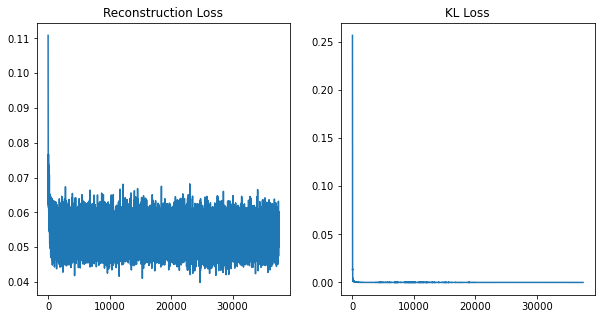

In [ ]:
learning_rate = 1e-3
nz = 32

####################################### TODO #######################################
# Tune the beta parameter to obtain good training results. However, for the    #
# initial experiments leave beta = 0 in order to verify our implementation.        #
####################################################################################
epochs = 20 # works with fewer epochs than AE, VAE. we only test conditional samples.
beta = 0.05
#################################### END TODO ######################################

# build CVAE model
conditional = True
cvae_model = CVAE(nz, beta, conditional=conditional, num_labels=10).to(device)    # transfer model to GPU if available
cvae_model = cvae_model.train()   # set model in train mode (eg batchnorm params get updated)

# build optimizer and loss function
####################################### TODO #######################################
# Build the optimizer for the cvae_model. We will again use the Adam optimizer with #
# the given learning rate and otherwise default parameters.                        #
####################################################################################
optimizer = Adam(cvae_model.parameters(), lr=learning_rate)
# same as AE
#################################### END TODO ######################################

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")
for ep in range(epochs):
  print(f"Run Epoch {ep}")
  ####################################### TODO #######################################
  # Implement the main training loop for the model.                                  #
  # If using conditional VAE, remember to pass the conditional variable c to the     #
  # forward pass                                                                     #
  # HINT: Your training loop should sample batches from the data loader, run the     #
  #       forward pass of the model, compute the loss, perform the backward pass and #
  #       perform one gradient step with the optimizer.                              #
  # HINT: Don't forget to erase old gradients before performing the backward pass.   #
  # HINT: As before, we will use the loss() function of our model for computing the  #
  #       training loss. It outputs the total training loss and a dict containing    #
  #       the breakdown of reconstruction and KL loss.                               #
  ####################################################################################
  for train_it, (features, ground_truth) in enumerate(mnist_data_loader):
    features = torch.reshape(features, (features.size()[0], -1))
    features = features.to(device)
    #print(features.size())
    optimizer.zero_grad()
    q_reconstruction = cvae_model(features, ground_truth)
    total_loss, losses = cvae_model.loss(features, q_reconstruction)
    rec_loss.append(losses['rec_loss'].detach()); kl_loss.append(losses['kl_loss'].detach())
    total_loss.backward()
    optimizer.step()

    if train_it % 100 == 0:
      print("It {}: Total Loss: {}, \t Rec Loss: {},\t KL Loss: {}"\
            .format(train_it, total_loss, losses['rec_loss'], losses['kl_loss']))
    train_it += 1
  #################################### END TODO ####################################

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
fig = plt.figure(figsize = (10, 5))
ax1 = plt.subplot(121)
ax1.plot(rec_loss_plotdata)
ax1.title.set_text("Reconstruction Loss")
ax2 = plt.subplot(122)
ax2.plot(kl_loss_plotdata)
ax2.title.set_text("KL Loss")
plt.show()

### Verifying conditional samples from CVAE [6 pt]
Now let us generate samples from the trained model, conditioned on all the labels.

<Figure size 432x288 with 0 Axes>

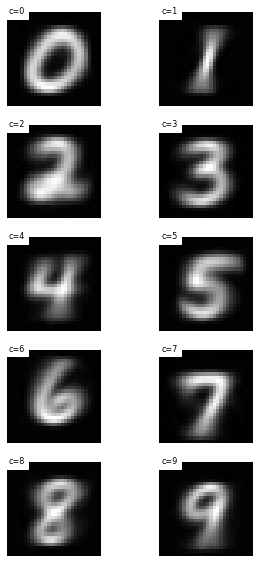

In [ ]:
# Prob1-9
if conditional:
    c = torch.arange(0, 10).long().unsqueeze(1).to(device)
    z = torch.randn([10, nz]).to(device)
    x = cvae_model.decoder(z, c=c)
else:
    z = torch.randn([10, nz]).to(device)
    x = cvae_model.decoder(z)

plt.figure()
plt.figure(figsize=(5, 10))
for p in range(10):
    plt.subplot(5, 2, p+1)
    if conditional:
        plt.text(
            0, 0, "c={:d}".format(c[p].item()), color='black',
            backgroundcolor='white', fontsize=8)
    plt.imshow(x[p].view(28, 28).cpu().data.numpy(), cmap='gray')
    plt.axis('off')

# Submission Instructions

You need to submit this jupyter notebook and a PDF. See Piazza for detailed submission instructions.